In [231]:
from bert_embedding import BertEmbedding
  
import numpy as np 
import pandas as pd
  
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [3]:
CITY = 'sydney'

In [4]:
def zomatoPreprocess(city):

    zomato = pd.read_csv('data/'+city+'.csv')
    zomato = zomato[['name','cuisines']].dropna(axis=0)

    cuisines = zomato.cuisines.apply(lambda x:x.replace('[','')
                                                .replace(']','')
                                                .replace('"','')
                                                .replace(',',' ')
                                                .replace('and','') + ' food'
                                                .replace('  ',' ')).values

    names = zomato.name.values
    
    return cuisines, names

In [5]:
zomatoPreprocess(CITY)

(array(['Malaysian Asian Chinese Asian Fusion Singaporean food',
        'Japanese food', 'Modern Australian food', ...,
        'Beverages Healthy Food food', 'Fast Food Burger food',
        'Others food'], dtype=object),
 array(['Ho Jiak 好吃', 'Sokyo', 'Bennelong Restaurant', ..., 'Blitz Juice',
        "McDonald's", "Baker's Delight"], dtype=object))

# BERT: Bidirectional Encoder Representations from Transformers

#### Abstract:

We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT representations can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE benchmark to 80.4% (7.6% absolute improvement), MultiNLI accuracy to 86.7 (5.6% absolute improvement) and the SQuAD v1.1 question answering Test F1 to 93.2 (1.5% absolute improvement), outperforming human performance by 2.0%.

.

###### This notebook uses the bert-embeddings pypi package which builds off of gluon-nlp https://pypi.org/project/bert-embedding/

.

In [6]:
def stack(embeddings,stacked=[],n=0):

    if len(stacked)>0: x = stacked
    else: x = embeddings[0]
    
    try:stacked = np.add(np.array(x), embeddings[1])
    except:return np.array(x)
    
    n += 1
    
    return stack(embeddings[1:],stacked=stacked,n=n)



def __bagofBERTs(restaurants,berts):
    
    output = []
    
    for restaurant,(cuisines,embeddings) in zip(restaurants,berts):
        embedding = stack(embeddings)
        output += [(restaurant,cuisines,embedding)]
        
    return output



def getEmbeddings(n_restaurants=100,city=CITY):
    
    print('Cleaning Zomato data for {}.\n'.format(city))
    cuisines, names = zomatoPreprocess(CITY.lower())
    
    print('Retrieving BERT sentence representations for {} restuarants...\n'.format(n_restaurants))
    __bert_embedding = BertEmbedding(model='bert_12_768_12')
    __berts = __bert_embedding(cuisines[:n_restaurants])
    bagofembeddings = __bagofBERTs(names, __berts)
    
    print('Complete.')
    
    filtrd = [(n,c,e) for n,c,e
              in bagofembeddings 
                  if len(e.shape)>0]

    cuisines = [c for n,c,e in filtrd]
    embeds = [e for n,c,e in filtrd]
    names = [n for n,c,e in filtrd]
    
    return names,cuisines,embeds,bagofembeddings
    

In [7]:
names, cuisines, embeds, bag = getEmbeddings(n_restaurants=1000)

Cleaning Zomato data for sydney.

Retrieving BERT sentence representations for 1000 restuarants...

Complete.


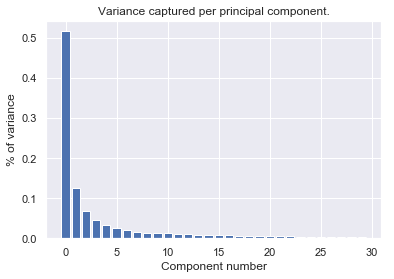

In [8]:
pca = PCA(n_components=30)
principal_components = pca.fit_transform(embeds)

pca0 = principal_components[:,0]
pca1 = principal_components[:,1]
pca2 = principal_components[:,2]

summed = sum(pca.explained_variance_)

plt.bar(range(len(pca.explained_variance_)),[i/summed for i in (pca.explained_variance_)])
plt.title('Variance captured per principal component.')
plt.ylabel('% of variance')
plt.xlabel('Component number')
plt.show()

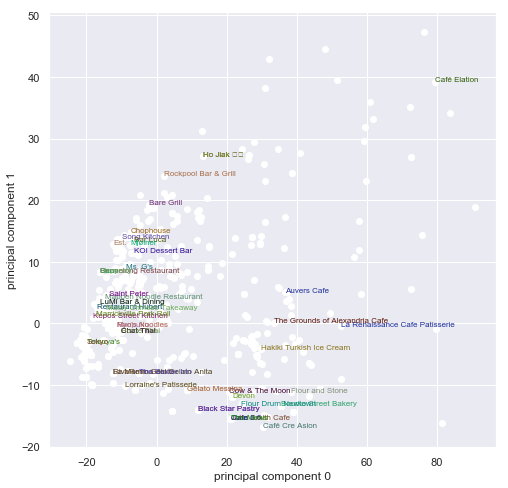

In [225]:
plt.figure(figsize=(8,8))
plt.scatter(pca0,pca1,c='white')
for i, x, y in zip(names, pca0[:50], pca1[:50]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=8)
plt.xlabel('principal component 0')
plt.ylabel('principal component 1')
plt.show()

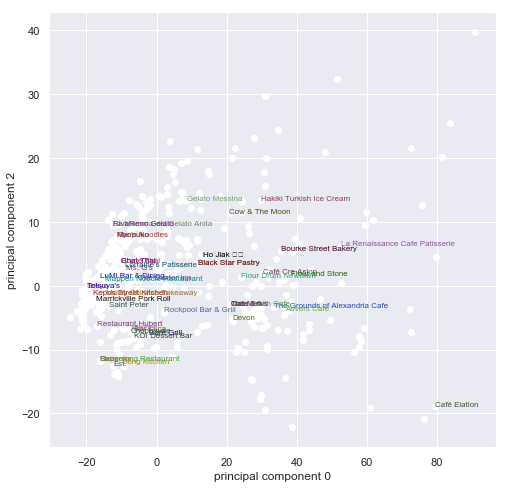

In [224]:
plt.figure(figsize=(8,8))
plt.scatter(pca0,pca2,c='white')
for i, x, y in zip(names, pca0[:50], pca2[:50]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=8)
plt.xlabel('principal component 0')
plt.ylabel('principal component 2')
plt.show()

In [118]:
from scipy.spatial.distance import cosine, euclidean

Cosine similarity for nearest neighbours search:
$$similarity = cos(\theta) = \frac{A \cdot B}{||A||\,||B||} = \frac{\sum_{i=1}^nA_iB_i}{\sqrt{\sum_{i=1}^nA_i^2} {\sqrt{\sum_{i=1}^nB_i^2}}}$$

In [690]:
def nearest_neighbours(embeddings,from_index=None,from_name=None,names=names,to_df=True,cos=True):
    
    if from_index==None and from_name!=None: from_index = names.index(from_name)
        
    from_emb = embeddings[from_index]
    from_name = names[from_index] if from_name==None else from_name
    
    if cosine: dist = lambda x: cosine(from_emb,x)
    else: dist = lambda x: euclidean(from_emb,x)
    
    nn = sorted([(to_name,dist(to_emb)) 
                     for to_emb,to_name in zip(embeddings,names)]
                
                ,key=lambda x:x[1]
                ,reverse=False)
    
    if to_df: nn = pd.DataFrame(nn,columns=['name','distance']).drop_duplicates()
    
    return from_name,nn

In [241]:
restaurant, nn = nearest_neighbours(embeds,8)
print('Restaurants most similar to:',restaurant,'\n')
nn.head(20)

Restaurants most similar to: Bare Grill 



,name,distance
0,Bare Grill,0.000000
2,Bar Luca,0.042479
3,Chophouse,0.066470
4,BLACK Bar & Grill,0.066470
5,Kingsleys Woolloomooloo,0.066470
6,Kingsleys Australian Steakhouse,0.066470
7,Hurricane's Grill- Darling Harbour,0.074416
8,Hurricane's Grill,0.074416
9,Hurricane's Grill Brighton-Le-Sands,0.074416
10,Elements Bar and Grill,0.080474


#### Plotting helpers

In [120]:
##### Graph for dist of merchants across labels

def plot_label_dist(cluster,palette='inferno',figsize=(10,5),flip_axes=False):
    labels = sorted(cluster.labels_.astype(float))
    Y = [labels.count(x) for x in set(labels)]
    X = list(set(labels))
    
    plt.figure(figsize=figsize)
    if flip_axes: sns.barplot(Y,X,palette=palette)
    else: sns.barplot(X,Y,palette=palette)
    plt.xlabel('Cluster label')
    plt.ylabel('# of member restaurants')

    plt.title('distribution across {} clusters'.format(len(set(labels))))
    plt.show()

In [124]:
##### Graph for coloured scatterplot

def plot_clusters(cluster
                  ,pc=principal_components
                  ,text=False
                  ,n_names=10
                  ,centroids=False
                  ,figsize=(6,6)
                  ,multiple_plots=False
                  ,labels=[]
                  ,title=''):
    sns.set()
    pca0 = pc[:,0]
    pca1 = pc[:,1]
    pca2 = pc[:,2]
    
    if len(labels)==0:
        labels = cluster.labels_
    
    if centroids: centroid_plot = cluster.cluster_centers_
    n = 2 if multiple_plots else 1
    
    for i,other_pc in enumerate([pca1,pca2][:n]):
        count=0
        
        plt.figure(figsize=figsize)
        plt.scatter(x=pca0,y=other_pc
                    ,c=labels.astype(float)
                    , s=50
                    , alpha=0.5)
        if centroids: plt.scatter(centroid_plot[:,0], centroid_plot[:,1], c='blue', s=50)
        
        # Add merchant name annontations
        if text:
            for n, (j, x, y) in enumerate(zip(names, pca0, other_pc)):
                if count>n_names: break
                if np.random.rand(1)[0]>0.8:
                    count+=1
                    
                    xytexts = [+3,-3,+5,-5,+7,-7]
                    xco = np.random.choice(xytexts); yco = np.random.choice(xytexts)

                    plt.annotate(j, xy=(x, y),xytext=(x+xco, y+yco),fontsize=10,
                        arrowprops=dict(facecolor=np.random.rand(3), shrink=0.05),)

        plt.title('{}'.format(title))
        plt.show()

In [122]:
##### plot for 3d scatterplot, colour coded by label

def plot_3d_clusters(clusters
                     ,text=False
                     ,n_names=8
                     ,pc=principal_components
                     ,figsize=(6,6)):
    
    from mpl_toolkits.mplot3d import Axes3D
    np.random.seed(5)

    X = pc[:,0]
    Y = pc[:,1]
    Z = pc[:,2]

    fignum = 1

    for name,est in clusters:
        count=0
        fig = plt.figure(fignum, figsize=figsize)
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

        ax.scatter(X, Y, Z,
                   c=est.labels_.astype(float), edgecolor='k')

        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        ax.set_xlabel('component0')
        ax.set_ylabel('component1')
        ax.set_zlabel('component2')
        ax.set_title(name)
        ax.dist = 12
        fignum = fignum + 1
        
    if text:
        for n, (j, x, y, z) in enumerate(zip(names, X,Y,Z)):
            if count>n_names: break
            if np.random.rand(1)[0]>0.5:
                count+=1

                xytexts = [+3,-3,+5,-5,+7,-7]
                xco = np.random.choice(xytexts); yco = np.random.choice(xytexts)

                plt.annotate(j, xy=(x, y),xytext=(x+xco, y+yco),fontsize=10,
                    arrowprops=dict(facecolor=np.random.rand(3), shrink=0.05),)

    fig.show()    


# Comparison of clustering algorithms

#### Kmeans++

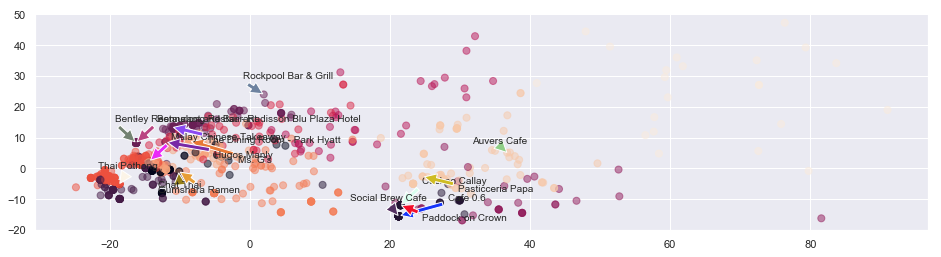

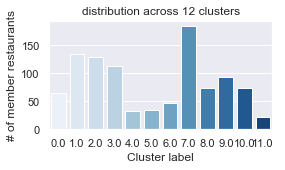

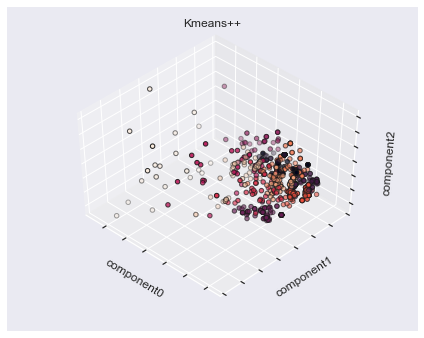

In [237]:
kplus = KMeans(n_clusters=12,init='k-means++').fit(embeds)
plot_clusters(kplus,text=True,n_names=15,figsize=(16,4))
plot_label_dist(kplus,palette='Blues',figsize=(4,2))
plot_3d_clusters([('Kmeans++',kplus)],figsize=(6,4.5))

#### Affinity Propagation

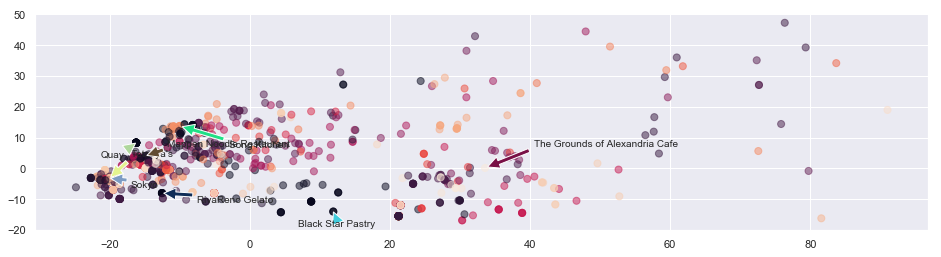

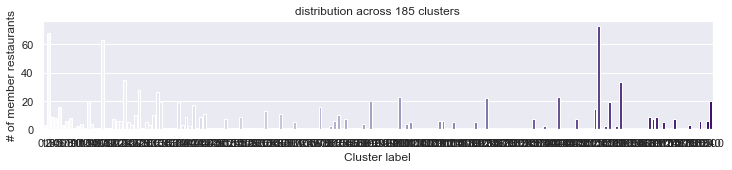

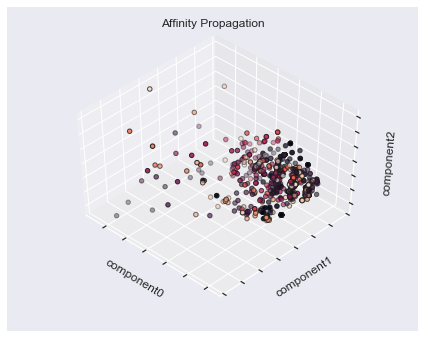

In [235]:
affiProp = AffinityPropagation().fit(embeds)
plot_clusters(affiProp,text=True,n_names=7,figsize=(16,4))
plot_label_dist(affiProp,palette='Purples',figsize=(12,2),flip_axes=False)
plot_3d_clusters([('Affinity Propagation',affiProp)],figsize=(6,4.5))

#### Agglomerative (hierarchical) clustering 

In [54]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [238]:
def minimal_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    city = kwargs["city"]
    del kwargs["city"]
    
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram for {}'.format(city))
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [66]:
l = linkage(embeds, method='complete', metric='seuclidean')

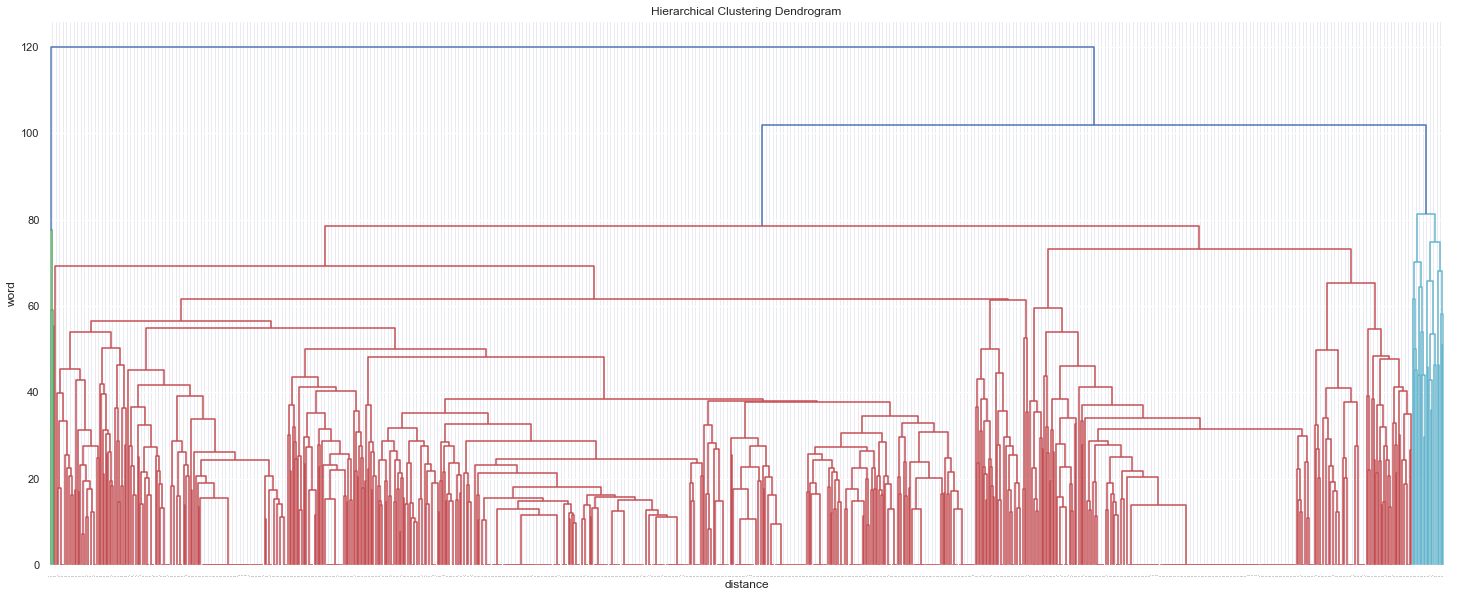

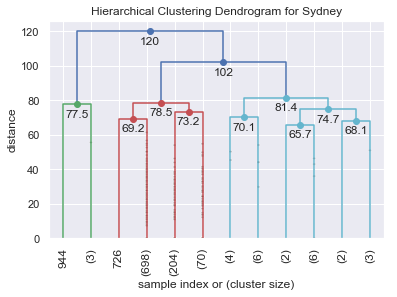

In [239]:
# calculate full dendrogram

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=0.,  # font size for the x axis labels
    orientation='top',
)
plt.show()

minimal_dendrogram(
    l,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    city='Sydney'
)
plt.show()

#### Copheretic correlation

A statistic that measures how well the denodogram preserves pairwise relations between datapoints. Above 0.8 is a useful baseline.

For embeddings modelled with an hierarichal cluster method to produce a dendrogram $$X_i \longrightarrow T_i$$

we define the following distance measures for the ith and jth observations:

$$Euclid.dist\;=\; x(i, j)\; =\; | X_i − X_j |$$
$$Dendrog.dist\;=\;t(i, j)\; = var(min(C(i,j)))$$

where *t(i,j)* is the item-wise variance of the lowest cluster (via Ward's metric) that *i and j* co-inhabit.

Then, letting $$\bar{x} = \frac{\sum_{i=1}^nx(i, j)}{n}$$$$\bar{t} = \frac{\sum_{i=1}^nt(i,j)}{n}$$

the cophenetic correlation is equal to:

$$c = \frac{\sum_{i<j}(x(i,j)-\bar{x})(t(t,j)-\bar{t})}{\sqrt{[\sum_{i<j}(x(i,j)-\bar{x})^2][\sum_{i<j}(t(i,j)-\bar{t})^2]}}$$

.

###### As c approaches 1, the pairwise preservation improves.

In [201]:
corr, coph_dists = cophenet(l, pdist(embeds))
print('\nCophenetic correlation:', corr,'\n')


Cophenetic correlation: 0.8108816319478815 



Large clusters n:
3 

Medium clusters n:
13 

Small clusters n:
34 

Tiny clusters n:
121 



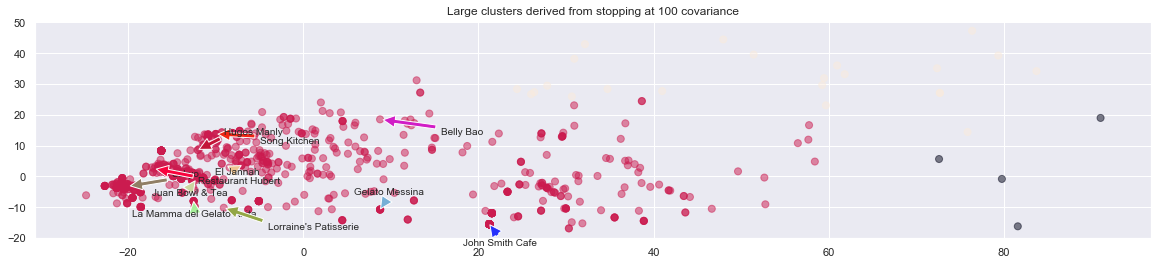

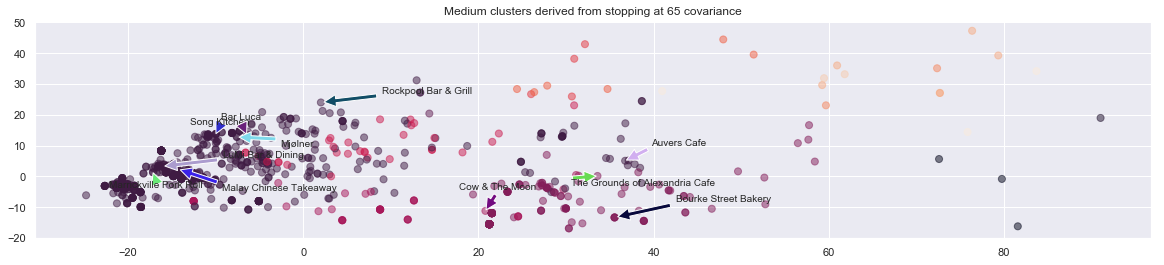

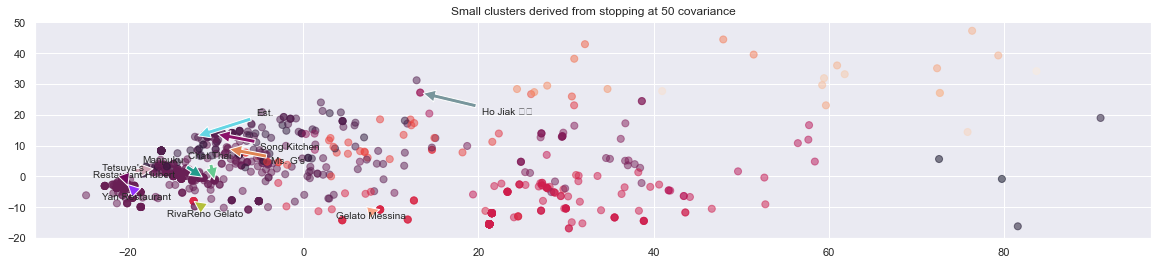

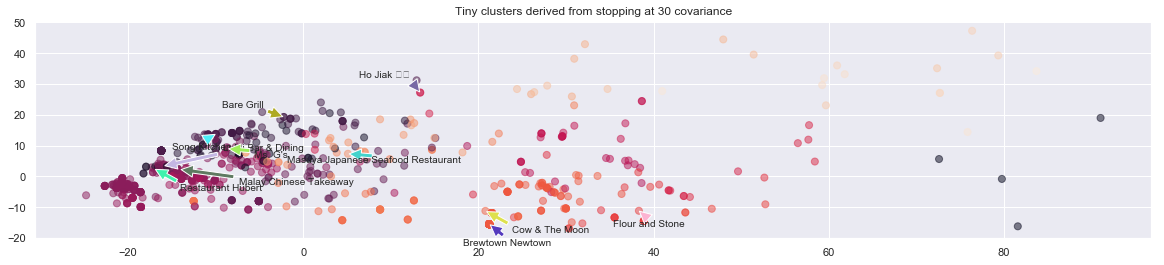

In [204]:
t_values = [('Large clusters',100),('Medium clusters',65),('Small clusters',50),('Tiny clusters',30)]

agglom_labels = []

for label,t_value in t_values:
    print(label,'n:')
    clusters = fcluster(l, t=t_value, criterion='distance')
    print(len(np.unique(clusters)),'\n')

    agglom_labels += [clusters]
    
agglom_labels = np.array(agglom_labels)




for i in range(len(agglom_labels)): 
    plot_clusters(l,pc=principal_components
                  ,labels=agglom_labels[i]
                  ,text=True,figsize=(20,4)
                  ,title=('{} derived from stopping at {} covariance'
                         ).format(t_values[i][0],t_values[i][1]))
    plt.show()

In [226]:
### Build a cluster labels dataframe

metadata_df = pd.DataFrame(zip(names,cuisines,principal_components[:,0],
                            principal_components[:,1],
                            principal_components[:,2])
                           ,columns=['name','cuisines','pca_0','pca_1','pca_2'])

metadata_df['agglomerative_l'] = agglom_labels[0]
metadata_df['agglomerative_m'] = agglom_labels[1]
metadata_df['agglomerative_s'] = agglom_labels[2]
metadata_df['agglomerative_t'] = agglom_labels[3]
metadata_df['kmeans++'] = kplus.labels_
metadata_df['affinity_propagation'] = affiProp.labels_


embeddings_df = pd.DataFrame(embeds)
embeddings_df['name'] = names

In [693]:
def meta_nearest_neighbours(metadata_df=metadata_df
                            ,embeddings=embeds
                            ,names=names
                            ,from_index=None
                            ,from_name=None):
    
    from_item, nn_df = nearest_neighbours(embeddings
                                         ,from_index=from_index
                                         ,from_name=from_name
                                         ,names=names
                                         ,to_df=True)

    return from_item, nn_df.merge(metadata_df).sort_values(by='distance').drop_duplicates(subset='name')

In [696]:
item,nn = meta_nearest_neighbours(from_name='Aqua S')

In [697]:
cluster_names = ['kmeans++','affinity_propagation'
                 ,'agglomerative_l','agglomerative_m'
                 ,'agglomerative_s','agglomerative_t']

print('Nearest neighbours for',item)

nn[['name',
    'agglomerative_l',
    'agglomerative_m',
    'agglomerative_s',
    'agglomerative_t',
    'affinity_propagation',
    'kmeans++']].head(5)


Nearest neighbours for Aqua S


,name,agglomerative_l,agglomerative_m,agglomerative_s,agglomerative_t,affinity_propagation,kmeans++
0,Aqua S,2,6,19,86,2,8
1,Gelateria Gondola,2,6,19,87,3,8
2,Gelato Messina,2,6,19,87,3,8
9,Cow & The Moon,2,6,19,82,109,4
15,Gelato Franco,2,6,19,86,2,0


# Evaluation

###### NDCG @k (Normalized-discounted Culumative gain)


https://hivemall.incubator.apache.org/userguide/eval/rank.html

In [796]:
import math
from collections import defaultdict


def ndcg(ranking
         ,cluster_cardinality
         ,binary=True
         ,receptive_field=1):
    
    dcg = lambda x: sum([rel/math.log(pos+2) for pos,rel in enumerate(x)])
    
    n = len(ranking) if (len(ranking) < cluster_cardinality) else cluster_cardinality
    
    actual_dcg = dcg(ranking)
    ideal_dcg = dcg([1] * n)
    normalized_dcg = actual_dcg / ideal_dcg
    
    return normalized_dcg


def rank_scores(item
                ,nn
                ,binarize=True
                ,k=10
                ,cluster_names=cluster_names):
    """
    Input: 
        nearest neighbours dataframe,
        k to represent size of list.
    
    Returns:
        A binarized ranking, where 1 is assigned to
    entries with matching clusters, and 0 otherwise.
    """
    
    rankings = {}
    
    nn.sort_values(by='distance')
    from_item = nn[nn.name==item]
    nn = nn[nn.name!=item]
    
    binarizer = lambda x:1 if x==0 else 0
    
    for c in cluster_names:
        n_clusters = len(set(nn[c].values))
        clusters = nn[c].values[:k]
        ground_truth = int(from_item[c])
        ground_size = nn[nn[c]==ground_truth].shape[0]
        
        continuous = [( abs(ground_truth - c) / ground_truth )
                        for c in list(clusters)]
        
        binarized = [binarizer(ground_truth-c) for c in clusters]
        
        rankings[c] = binarized if binarize else continuous
    
    return rankings


def evaluate(k
             ,names=names
             ,metric='ndcg'
             ,stop_at=50
             ,binary=True
             ,cluster_names=cluster_names):
    
    rankings = []
    
    for n in names[:stop_at]:
        item, nn = meta_nearest_neighbours(from_name=n)
        rankings += [(n,nn[nn.name==item],nn,rank_scores(item,nn,binarize=binary,k=k))]
    
    rows = []
    count = 0

    for n,item,nn,cluster_rankings in rankings:
        metrics = []
        
        for c in cluster_rankings.keys():
            ranking = cluster_rankings[c]
            cardinality = nn[nn[c]==item[c].values[0]].shape[0]
            metrics += [ndcg(ranking,cardinality)]
        
        metrics = [n] + metrics
        rows += [tuple(metrics)]
        
    metric_df = pd.DataFrame(rows,columns=['name'] + cluster_names)
    return metric_df

In [801]:
def results(top_k=20,stop_at=5):
    
    n_results = []
    b_results = []

    for i in range(1,top_k):
        print('{} of {} iterations complete...'.format(i-1,top_k))
        binary_df = evaluate(i,binary=True,stop_at=stop_at).drop('name',axis=1)
        normalized_df = evaluate(i,binary=False,stop_at=stop_at).drop('name',axis=1)

        b_results += [binary_df.apply(np.mean,axis=0).values]
        n_results += [normalized_df.apply(np.mean,axis=0).values]

        header = evaluation_df.apply(np.mean,axis=0).index

    binary_results = pd.DataFrame(b_results,columns=header)
    normalized_results = pd.DataFrame(n_results,columns=header)

    return [('binary',binary_results),('normalized',normalized_results)]

In [802]:
data = results(top_k=10,stop_at=500)

0 of 10 iterations complete...
1 of 10 iterations complete...
2 of 10 iterations complete...
3 of 10 iterations complete...
4 of 10 iterations complete...
5 of 10 iterations complete...
6 of 10 iterations complete...
7 of 10 iterations complete...
8 of 10 iterations complete...


In [809]:
data[0][1].to_csv('ndcg_binary.csv')

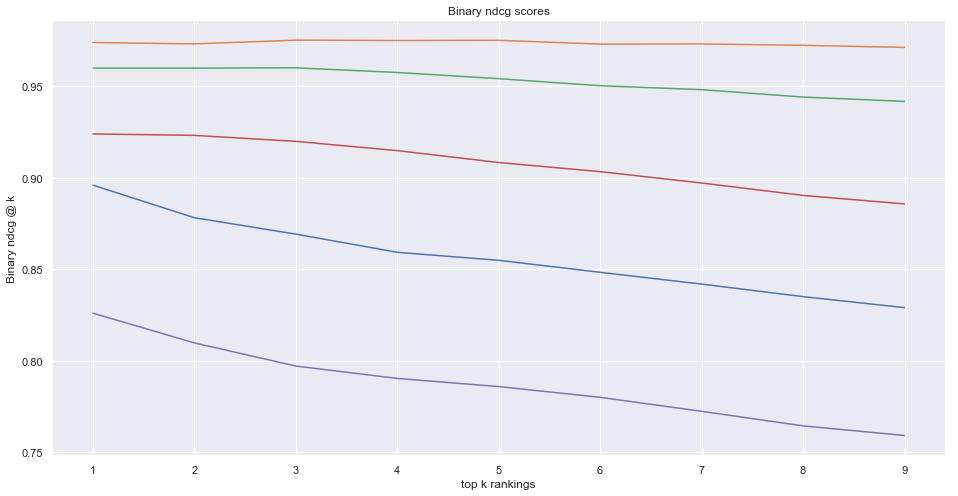

,kmeans++,affinity_propagation,agglomerative_l,agglomerative_m,agglomerative_s,agglomerative_t
0,0.896000,0.764000,0.974000,0.960000,0.924000,0.826000
1,0.878205,0.733825,0.973226,0.960000,0.923226,0.809752
2,0.869240,0.722090,0.975285,0.960144,0.919941,0.797095
3,0.859280,0.709393,0.975069,0.957612,0.914890,0.790330
4,0.854914,0.701582,0.975191,0.954223,0.908376,0.785874
5,0.848348,0.696131,0.973122,0.950356,0.903387,0.780003
6,0.841902,0.688286,0.973203,0.948214,0.897168,0.772344
7,0.835048,0.680671,0.972469,0.944159,0.890405,0.764383
8,0.829030,0.674798,0.971303,0.941800,0.885735,0.759129


In [807]:
X = range(1,10)

plt.figure(figsize=(16,8))

for Y in cluster_names:
    if Y=='affinity_propagation': pass
    else:
        sns.lineplot(y=Y,x=X,data=data[0][1],legend='full'
                        ).set(xlabel='top k rankings'
                             ,ylabel='Binary ndcg @ k'
                             ,title='Binary ndcg scores')

plt.show()

data[0][1]